<h1><center>GAN for MNIST Handwritten Digits</center></h1>
<h3><center>Baran Deniz Korkmaz  ,  Doğukan Kalkan</center></h3>



In this notebook, we will present a GAN architecture for generating handwritten digits after it is trained by MNIST dataset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pydot
import graphviz

from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import plot_model

In [2]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

In [3]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

In [4]:
# Build the Generator
generator = build_generator(img_shape, z_dim)

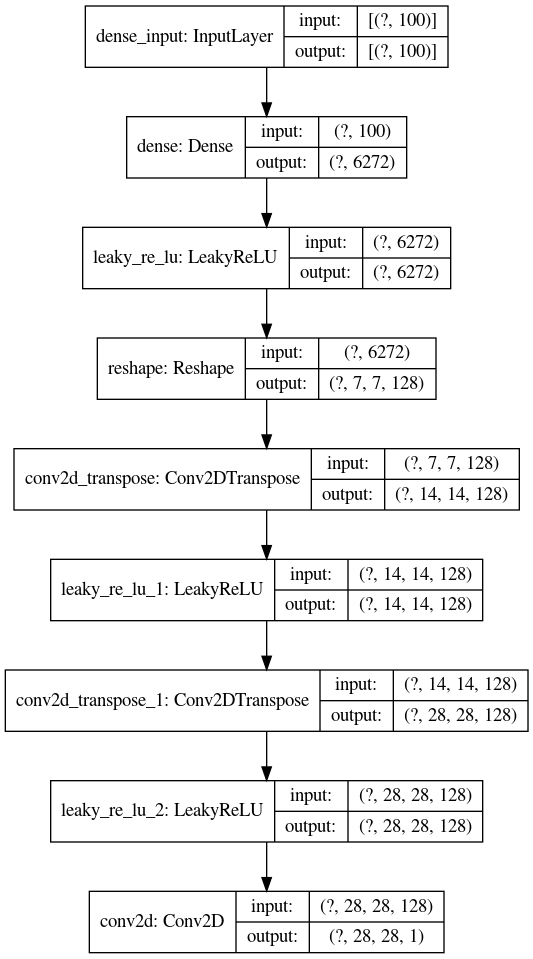

In [5]:
generator_img_path = './generator.png'
plot_model(generator, to_file=generator_img_path,show_shapes=True)

In the figure above, you can see the architecture of generator.

In [6]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [7]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

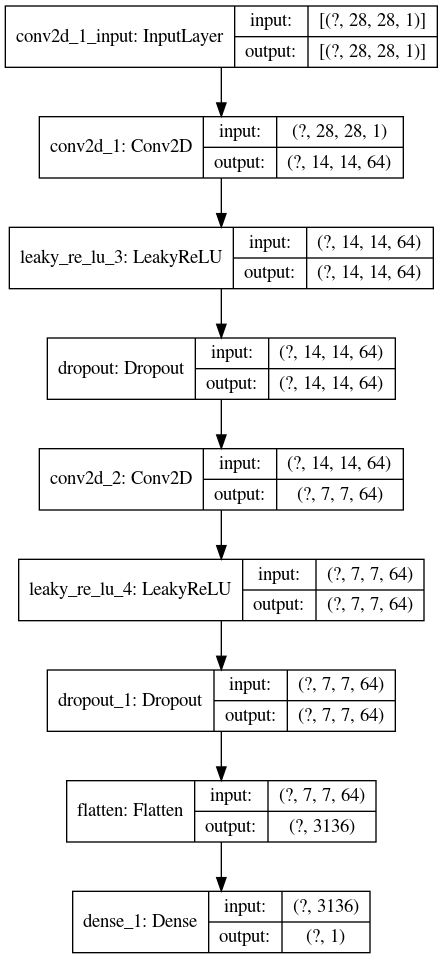

In [8]:
discriminator_img_path = './discriminator.png'
plot_model(discriminator, to_file=discriminator_img_path,show_shapes=True)

In the figure above, you can see the architecture of discriminator.

In [9]:
def build_gan(generator, discriminator):
    model = Sequential()
    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)
    return model

In [10]:
# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

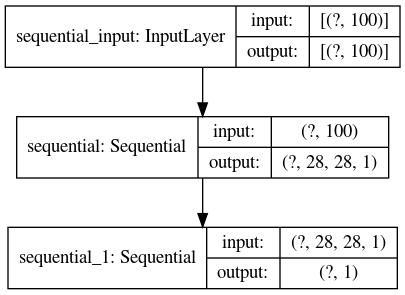

In [11]:
gan_img_path = './gan.png'
plot_model(gan, to_file=gan_img_path,show_shapes=True)

In the figure above, you can see the architecture of GAN.

In [12]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        #print("Real:",d_loss_real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        #print("Fake:",d_loss_fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)

In [13]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.show()

10 [D loss: 0.234243, acc.: 100.00%] [G loss: 1.050667]


/home/denizkorkmaz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


20 [D loss: 0.007681, acc.: 100.00%] [G loss: 4.412076]
30 [D loss: 0.000558, acc.: 100.00%] [G loss: 6.945904]
40 [D loss: 0.000313, acc.: 100.00%] [G loss: 7.512716]
50 [D loss: 0.000238, acc.: 100.00%] [G loss: 7.731070]
60 [D loss: 0.000359, acc.: 100.00%] [G loss: 7.807464]
70 [D loss: 0.000191, acc.: 100.00%] [G loss: 7.859054]
80 [D loss: 0.000181, acc.: 100.00%] [G loss: 8.049970]
90 [D loss: 0.000143, acc.: 100.00%] [G loss: 8.158705]
100 [D loss: 0.000163, acc.: 100.00%] [G loss: 8.244368]
110 [D loss: 0.000119, acc.: 100.00%] [G loss: 8.361920]
120 [D loss: 0.000107, acc.: 100.00%] [G loss: 8.526493]
130 [D loss: 0.000095, acc.: 100.00%] [G loss: 8.624860]
140 [D loss: 0.001283, acc.: 100.00%] [G loss: 8.791117]
150 [D loss: 0.000086, acc.: 100.00%] [G loss: 8.789618]
160 [D loss: 0.000082, acc.: 100.00%] [G loss: 8.834801]
170 [D loss: 0.000071, acc.: 100.00%] [G loss: 8.889549]
180 [D loss: 0.000064, acc.: 100.00%] [G loss: 9.024944]
190 [D loss: 0.000055, acc.: 100.00%] [

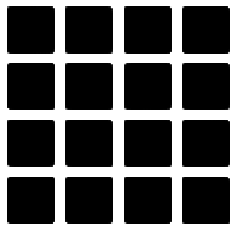

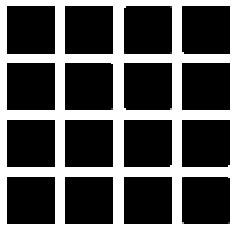

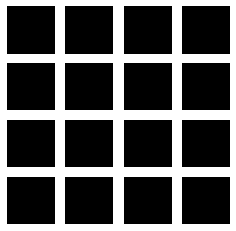

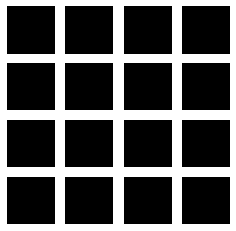

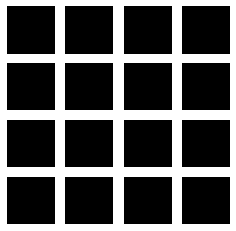

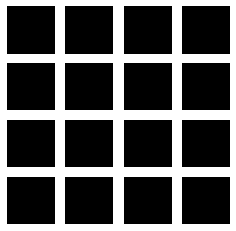

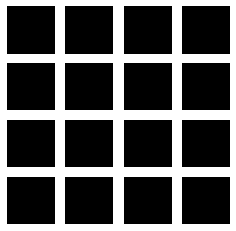

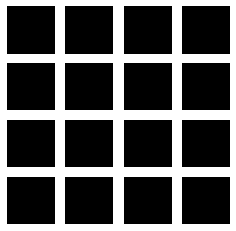

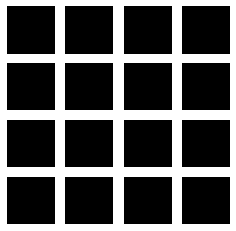

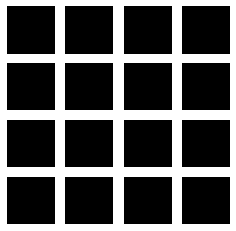

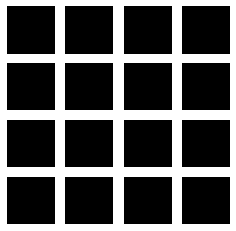

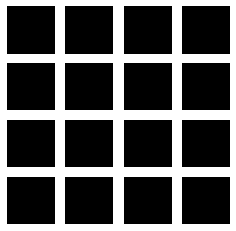

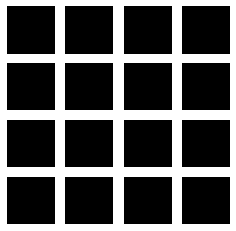

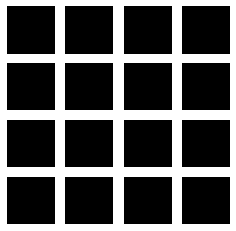

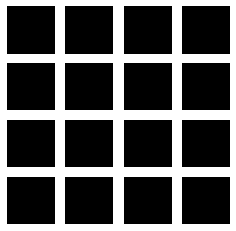

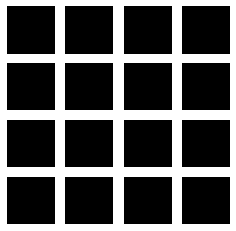

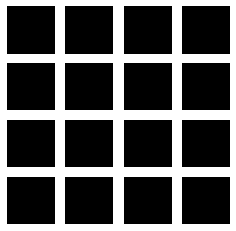

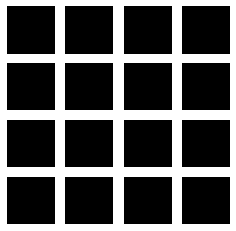

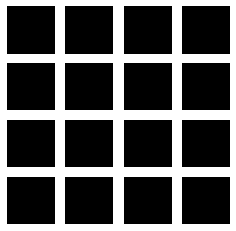

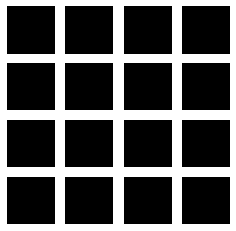

In [14]:
# Set hyperparameters
iterations = 200
batch_size = 128
sample_interval = 10

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

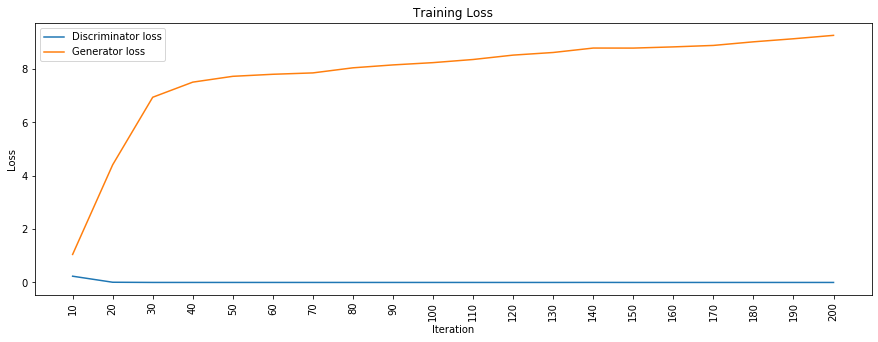

In [15]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

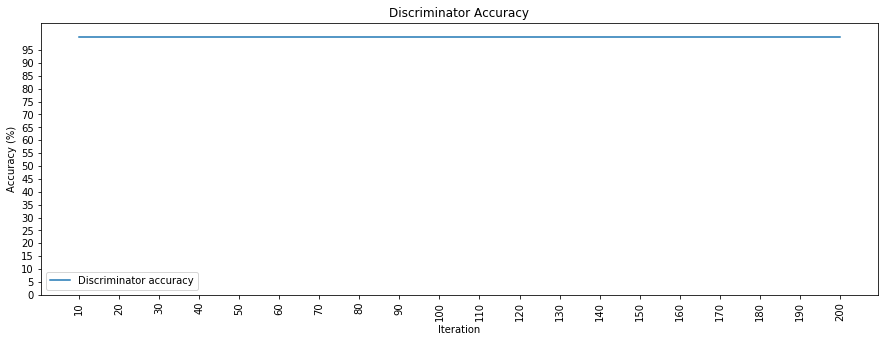

In [16]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

## References

* https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/